<a href="https://colab.research.google.com/github/A-Istrate/80629_Project/blob/main/ML_TPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import math
import copy
from random import seed
from random import random
import matplotlib.pyplot as plt  # import matplotlib for plotting and visualization
import matplotlib
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import os
import re
from tensorflow.keras import layers
from sklearn.utils import class_weight

Checking our images

In [3]:
## images path
path_s = r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers"
path = pathlib.Path(path_s)
image_count=len(list(path.glob('*/*.jpg')))
print(image_count)

53378


Checking a childrens book

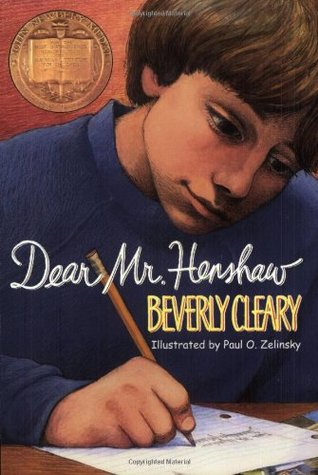

In [4]:
children = list(path.glob('Childrens/*'))
PIL.Image.open(str(children[12]))

Creating a dataset

In [5]:
batch_size =32
img_height = 150
img_width =100

list_ds = tf.data.Dataset.list_files(str(path_s+"\*/*.jp*"),shuffle=False)
list_ds = list_ds.shuffle(image_count,reshuffle_each_iteration=False)

In [6]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers\\Horror\\42080.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers\\Other\\50957.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers\\Other\\5980.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers\\Other\\24646.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers\\Other\\17168.jpg'


In [14]:
class_names = np.array(sorted([item.name for item in path.glob('*') if os.path.isdir(item)]))
print(class_names)

['Childrens' 'Classics' 'Cultural' 'Fantasy' 'Historical' 'History'
 'Horror' 'Mystery' 'Other' 'Poetry' 'Romance' 'Science Fiction'
 'Sequential Art' 'Young Adult']


In [7]:
val_size = int(image_count*0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [8]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

42703
10675


In [9]:
[object.numpy() for object in val_ds][0]

b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers\\Horror\\42080.jpg'

In [10]:
v2 = pd.DataFrame([re.findall("\d+\.jpg",str(object.numpy())) for object in val_ds])

In [11]:
%store -r final_genres_filtered

In [12]:
df_merge = pd.merge(v2,final_genres_filtered,left_on=0,right_on="img")

In [15]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [16]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [17]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    #if tf.io.is_jpeg(file_path):
     #   img = decode_img(img)
   # else:
     #   print("error : %s is not a jpg" %file_path)
    return img,label


In [18]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


Image shape:  (150, 100, 3)
Label:  13


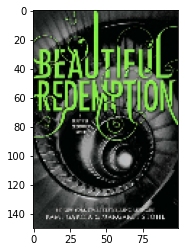

In [19]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  plt.imshow(image.numpy().astype("uint8"))

In [20]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  #print(ds)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

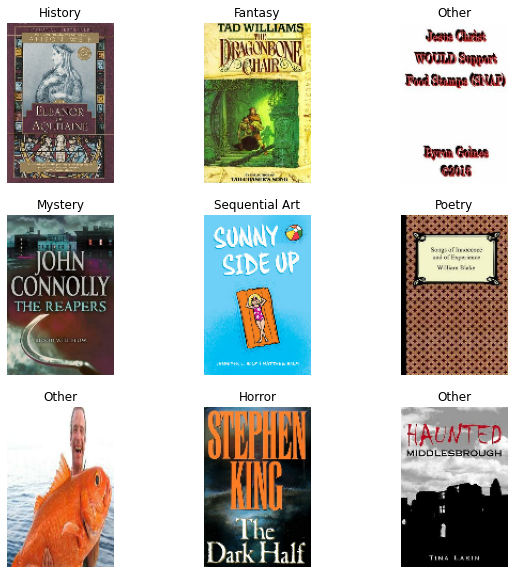

In [21]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

Classes

In [38]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
num_classes=14

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3,strides=1, activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(
    learning_rate=0.01, rho=0.9, momentum=0.0, epsilon=0.001, centered=True, 
    name='RMSprop'
),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [39]:
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
1335/1335 [==============================] - 191s 143ms/step - loss: 2.4575 - accuracy: 0.3525 - val_loss: 2.1538 - val_accuracy: 0.3644
Epoch 2/10
1335/1335 [==============================] - 190s 143ms/step - loss: 2.1661 - accuracy: 0.3595 - val_loss: 2.1544 - val_accuracy: 0.3644
Epoch 3/10
1335/1335 [==============================] - 192s 144ms/step - loss: 2.1648 - accuracy: 0.3593 - val_loss: 2.1523 - val_accuracy: 0.3644
Epoch 4/10
1335/1335 [==============================] - 190s 142ms/step - loss: 2.1666 - accuracy: 0.3581 - val_loss: 2.1523 - val_accuracy: 0.3644
Epoch 5/10
1335/1335 [==============================] - 189s 142ms/step - loss: 2.1632 - accuracy: 0.3599 - val_loss: 2.1518 - val_accuracy: 0.3644
Epoch 6/10
1335/1335 [==============================] - 191s 143ms/step - loss: 2.1642 - accuracy: 0.3591 - val_loss: 2.1524 - val_accuracy: 0.3644
Epoch 7/10
1335/1335 [==============================] - 193s 144ms/step - loss: 2.1635 - accuracy: 0.3598 - val_

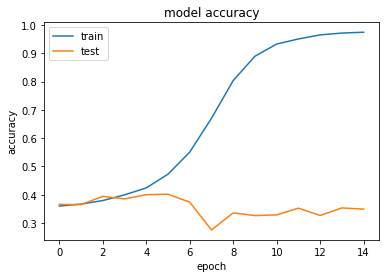

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
predictions = model.predict(val_ds)
predicted_classes = np.argmax(predictions, axis=1)

In [30]:
vclasses = list()
vclasses = [[c.numpy() for c in object[1]]for object in val_ds]

In [31]:
validation_classes = np.concatenate(vclasses).ravel()

In [32]:
from sklearn.metrics import classification_report
print(classification_report(validation_classes, predicted_classes, target_names=class_names))

                 precision    recall  f1-score   support

      Childrens       0.01      0.00      0.01       249
       Classics       0.05      0.04      0.05       595
       Cultural       0.02      0.02      0.02       275
        Fantasy       0.15      0.21      0.17      1556
     Historical       0.07      0.06      0.06       647
        History       0.01      0.01      0.01       244
         Horror       0.00      0.00      0.00       202
        Mystery       0.05      0.05      0.05       470
          Other       0.37      0.34      0.35      3890
         Poetry       0.02      0.01      0.01       191
        Romance       0.09      0.10      0.10       934
Science Fiction       0.05      0.04      0.04       403
 Sequential Art       0.02      0.03      0.03       296
    Young Adult       0.07      0.10      0.08       723

       accuracy                           0.18     10675
      macro avg       0.07      0.07      0.07     10675
   weighted avg       0.18   

In [ ]:
pv = pd.DataFrame(np.array([predicted_classes,validation_classes]).T,columns=("pred","val"))

In [ ]:
pv = pv.applymap(lambda x: class_names[x])

In [ ]:
compare = pd.concat([df_merge,pv],axis=1)

In [ ]:
v4 = val_ds.unbatch()

In [ ]:
list(v4.as_numpy_iterator())